## Begin to Automate Your  Workflow With Functions

Functions can be tricky to learn. In this lesson, you will see how to break down a workflow and create 
a new function that can be used over and over on your data. 

You will want to use functions for this automation assignment. 

In [1]:
# Import necessary packages
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
from rasterio.plot import plotting_extent
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep


# Get data and set working directory
data = et.data.get_data('ndvi-automation')
os.chdir(os.path.join(et.io.HOME,
                      "earth-analytics",
                      "data"))


In [2]:
# Get a list of each directory
path = os.path.join("ndvi-automation", "sites")

# Get a list of both site directories (We will talk more about automation next week)
sites = glob(path + "/*/")
sites

['ndvi-automation/sites/SJER/', 'ndvi-automation/sites/HARV/']

In [3]:
# Get the site name
site_name = os.path.basename(os.path.normpath(sites[0]))
site_name

'SJER'

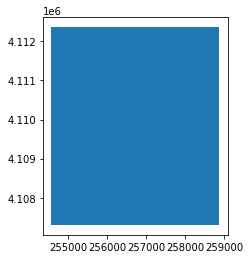

In [4]:
# Open up the shapefile for clipping your landsat data to the study area
vector_dir = os.path.join(sites[0],
                          "vector")

# Open crop boundary
site_boundary_path = os.path.join(vector_dir,  site_name + "-crop.shp")
crop_bound = gpd.read_file(site_boundary_path)
crop_bound.plot()
plt.show()

In [5]:
landsat_dir = os.path.join(sites[0],
                           "landsat-crop")
# This is the crop folder containing all of the .tif files
landsat_dir

'ndvi-automation/sites/SJER/landsat-crop'

In [6]:
# There are many subdirectories in here -- i will create a video that helps explain this
# process of creating lists of subdirectories  more for next week.
landsat_dirs = sorted(glob(os.path.join(landsat_dir, "LC08*")))
landsat_dirs

['ndvi-automation/sites/SJER/landsat-crop/LC080420342017010701T2-SC20181023153321',
 'ndvi-automation/sites/SJER/landsat-crop/LC080420342017012301T1-SC20181023170015',
 'ndvi-automation/sites/SJER/landsat-crop/LC080420342017020801T1-SC20181023162521',
 'ndvi-automation/sites/SJER/landsat-crop/LC080420342017022401T1-SC20181023152103',
 'ndvi-automation/sites/SJER/landsat-crop/LC080420342017031201T1-SC20181023152108',
 'ndvi-automation/sites/SJER/landsat-crop/LC080420342017032801T1-SC20181023162825',
 'ndvi-automation/sites/SJER/landsat-crop/LC080420342017041301T1-SC20181023170020',
 'ndvi-automation/sites/SJER/landsat-crop/LC080420342017042901T1-SC20181023153144',
 'ndvi-automation/sites/SJER/landsat-crop/LC080420342017051501T1-SC20181023151959',
 'ndvi-automation/sites/SJER/landsat-crop/LC080420342017053101T1-SC20181023151941',
 'ndvi-automation/sites/SJER/landsat-crop/LC080420342017061601T1-SC20181023152417',
 'ndvi-automation/sites/SJER/landsat-crop/LC080420342017070201T1-SC201810231

In [7]:
# Select just a single directory and grab bands 4-5 from the directory
adir = landsat_dirs[3]
# Open bands
band_paths = sorted(glob(os.path.join(adir, "*band*[4-5].tif")))
band_paths

['ndvi-automation/sites/SJER/landsat-crop/LC080420342017022401T1-SC20181023152103/LC08_L1TP_042034_20170224_20170301_01_T1_sr_band4.tif',
 'ndvi-automation/sites/SJER/landsat-crop/LC080420342017022401T1-SC20181023152103/LC08_L1TP_042034_20170224_20170301_01_T1_sr_band5.tif']

The focus of today is to look at using functions to apply cloud masks. I will create a video
for  next weeks' course that walks you through the above steps of automating
your workflow! Essentially you will want to create some for loops to cycle through
each set of sub directories. 


## Process a Single Band

There are two approaches that you could use here to create NDVI. You could chose to combine both 
bands into a single xarray object or because there are only two bands, you could process each individually.



In [8]:
band_paths

['ndvi-automation/sites/SJER/landsat-crop/LC080420342017022401T1-SC20181023152103/LC08_L1TP_042034_20170224_20170301_01_T1_sr_band4.tif',
 'ndvi-automation/sites/SJER/landsat-crop/LC080420342017022401T1-SC20181023152103/LC08_L1TP_042034_20170224_20170301_01_T1_sr_band5.tif']

### A Function  Worthy Workflow?

Below is a workflow that you will need to repeat over and over across all bands. 

Normally, when you are developing workflows you write it all out first using  a combination  of 
pseudocode and code. You fill in code and processing gaps as you go.

You can then see places where functions might be useful.
Some people start by deciding what functions they need. This is even more efficient but 
can be challenging if you are newer to data processing and programming.

Functions are useful for many different reasons - a few are below:

1. **They clean up your code following DRY (Dont Repeat Yourself):** ensuring you aren't repeating code. 
2. **They make changes to your code more efficient:** Once you have a function that is used over and over, any changes can be made  within that function! This is a win for you if you need to make updates
3. **They conserve resources by removing objects from memory:** Objects created within a function aren't available in the broader namespace (environment) of your notebook. Objects made wtihin the function are created why the function runs and then thrown away saving your compute resources. This makes your code cleaner and more efficient! 

In [9]:
# Open a single band using rioxarray
band = rxr.open_rasterio(band_paths[0], masked=True).squeeze()
# Clip the data
band_crop = band.rio.clip(crop_bound.geometry)

# Specify the valid range of values for landsat
valid_range = (0, 10000)

if valid_range:
    mask = ((band_crop < valid_range[0]) | (band_crop > valid_range[1]))
    band_crop = band_crop.where(~xr.where(mask, True, False))

band_crop

<xarray.DataArray (y: 168, x: 143)>
array([[267., 306., 443., ..., 500., 548., 468.],
       [346., 346., 494., ..., 579., 567., 503.],
       [422., 384., 456., ..., 615., 616., 529.],
       ...,
       [446., 558., 650., ..., 690., 626., 675.],
       [546., 652., 630., ..., 656., 685., 699.],
       [470., 512., 562., ..., 478., 650., 606.]])
Coordinates:
  * y            (y) float64 4.112e+06 4.112e+06 ... 4.107e+06 4.107e+06
  * x            (x) float64 2.546e+05 2.546e+05 ... 2.588e+05 2.588e+05
    band         int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

In [10]:
#  This function has the code from the workflow above
def open_clean_bands(band_path,
                     valid_range=None):
    """Open and mask a single landsat band using a pixel_qa layer.

    Parameters
    -----------
    band_path : string
        A path to the array to be opened
    valid_range : tuple (optional)
        A tuple of min and max range of values for the data. Default = None


    Returns
    -----------
    arr : xarray DataArray
        An xarray DataArray with values that should be masked set to 1 for True (Boolean)
    """
    # TODO add tests to ensure the arrays are the same .shape
    band = rxr.open_rasterio(band_path, masked=True).squeeze()

    # Only run this step if a valid range tuple is provided
    if valid_range:
        mask = ((band < valid_range[0]) | (band > valid_range[1]))
        band = band.where(~xr.where(mask, True, False))

    return band

## Apply your function

Using this function you can now crop and mask a single band in a single step!
Yes you could also chose to process multiple bands in this function or concat the 

xarray objects - there is where you could spend some time optimizing your code 

In [11]:
# Open and clean a single band
band_4 = open_clean_bands(band_path=band_paths[0],
                          # The range of valid values for landsat can include negative values
                          # for this week let's stick with 0-10000
                          valid_range=(0, 10000))

## But what about band 5?

There are decisions to be made here. For NDVI calculations you will want to have both  bands. 
You could chose to calculate each manually like this:

In [12]:
#%%timeit

# Open and clean a single band
band_4 = open_clean_bands(band_path=band_paths[0],
                          # The range of valid values for landsat can include negative values
                          # for this week let's stick with 0-10000
                          valid_range=(0, 10000))

# Open and clean a single band
band_5 = open_clean_bands(band_path=band_paths[1],
                          # The range of valid values for landsat can include negative values
                          # for this week let's stick with 0-10000
                          valid_range=(0, 10000))

#  Then  calculate NDVI
ndvi = es.normalized_diff(band_5.values.astype('f4'),
                          band_4.values.astype('f4'))


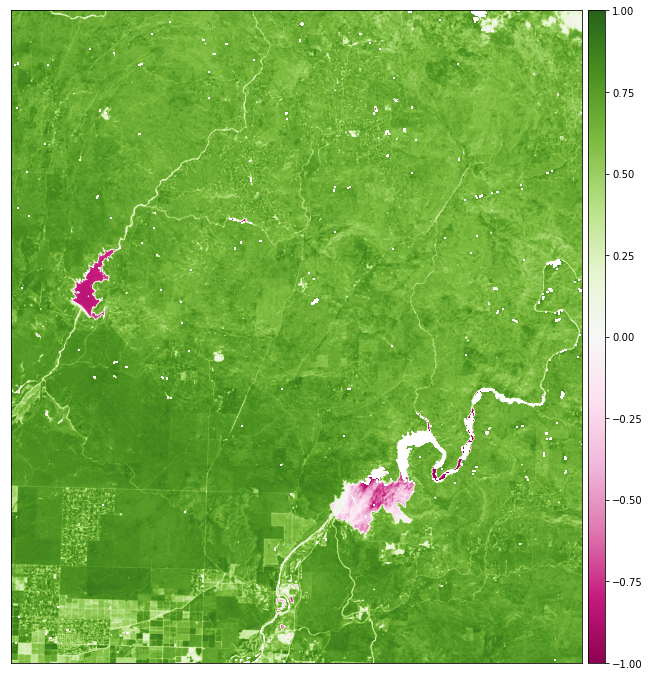

In [13]:
ep.plot_bands(ndvi,
              cmap='PiYG',
              vmin=-1)
plt.show()

Notice below the for loop removes some redundant code. 

In [14]:
# Recall that band_paths is a list of 2 bands - bands 4 and 5
# because  you sorted the data you know what order it will be in
band_paths

['ndvi-automation/sites/SJER/landsat-crop/LC080420342017022401T1-SC20181023152103/LC08_L1TP_042034_20170224_20170301_01_T1_sr_band4.tif',
 'ndvi-automation/sites/SJER/landsat-crop/LC080420342017022401T1-SC20181023152103/LC08_L1TP_042034_20170224_20170301_01_T1_sr_band5.tif']

In [15]:
# import pyproj
# pyproj.set_use_global_context(True)

In [16]:
# %%timeit
# uncomment the above if you want to time this cell -
# i suggest commenting out the print statement in the for loop if you time the cell
# Alternatively do this in a loop and create a list output -
all_bands = []
for aband in band_paths:
    print("Opening up", aband)
    cleaned_band = open_clean_bands(band_path=aband,
                                    # The range of valid values for landsat can include negative values
                                    # for this week let's stick with 0-10000
                                    valid_range=(0, 10000))
    all_bands.append(cleaned_band)


# Then calculate NDVI

ndvi_2 = (all_bands[1]-all_bands[0]) / (all_bands[1]+all_bands[0])


Opening up ndvi-automation/sites/SJER/landsat-crop/LC080420342017022401T1-SC20181023152103/LC08_L1TP_042034_20170224_20170301_01_T1_sr_band4.tif
Opening up ndvi-automation/sites/SJER/landsat-crop/LC080420342017022401T1-SC20181023152103/LC08_L1TP_042034_20170224_20170301_01_T1_sr_band5.tif


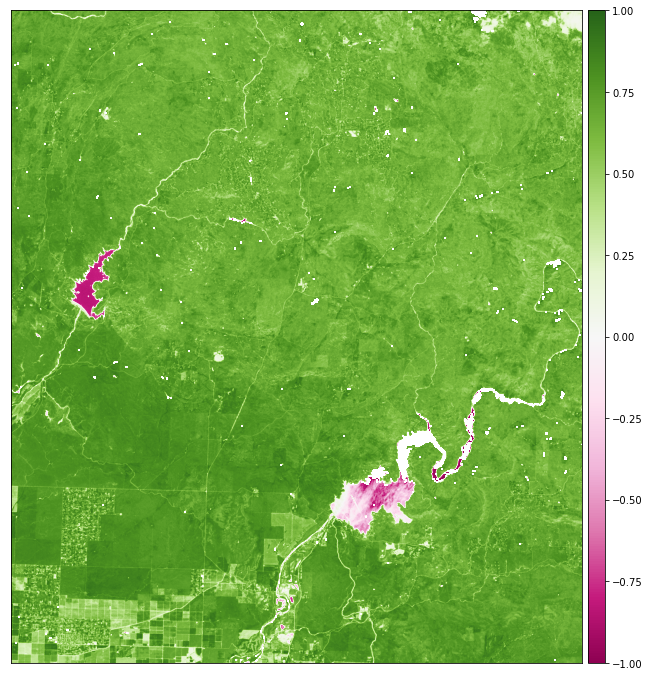

In [17]:
# You will want to grab a mean value but this is just a demo
ep.plot_bands(ndvi_2.values,
              cmap='PiYG',
              vmin=-1)
plt.show()

Almost  done -  time to crop your NDVI data using the function that you created above.  
For the purposes fo your homework - you could consider returning a mean NDVI value for the clipped data
as an option. 
 

In [18]:
# Open up the cloud mask layer

# Cloud no data vals for Landsat 8 -
vals = [328, 392, 840, 904, 1350, 352, 368, 416,
        432, 480, 864, 880, 928, 944, 992, 480, 992]

# Open cloud mask layer
qa_xr_path = glob(os.path.join(adir, "*qa*"))

# Clip the cloud mask layer
cl_mask = rxr.open_rasterio(qa_xr_path[0], masked=True).squeeze()

# View unique values in the data -note that not every landsat band will have clouds to mask
np.unique(cl_mask.values)

array([322., 324., 328., 336., 352., 386., 392., 416., 480., 834., 836.,
       992.])

## Create Final NDVI data

Note that for your homework you are working towards a mean NDVI value so there is another step.
You could decide to add that step to the NDVI function `mask_crop_ndvi` as an option!


For each scene you will need to:
    
1. calculate NDVI
2. Clip the data and 
3. apply the cloud mask

You  may want to calculate a mean as well in this function.

In [19]:
# Create clip object for NDVI and cloud  mask
crop_json = crop_bound.geometry

# Clip pixel qa cloud mask layer
cl_mask_crop = cl_mask.rio.clip(crop_json)


#  Calculate NDVI
ndvi_xr = (all_bands[1]-all_bands[0]) / (all_bands[1]+all_bands[0])

# Clip NDVI layer
ndvi_crop = ndvi_xr.rio.clip(crop_json)

# Apply cloud mask to NDVI
ndvi_crop = ndvi_crop.where(~cl_mask_crop.isin(vals))

The function below has more comments than you need. I've added them to it
is clear what each line does. 

In [20]:
# Turn  the above into a function
#  This could also easily be two functions
def mask_crop_ndvi(all_bands,
                   crop_bound,
                   pixel_qa,
                   vals):
    """Open and mask a single landsat band using a pixel_qa layer.

    Parameters
    -----------
    all_bands : list
        a list containing the xarray objects for landsat  bands 4 and  5
    crop_bound: geopandas GeoDataFrame
        A geopandas dataframe to be used to crop the raster data using rasterio mask().
    pixel_qa: xarray DataArray
        An xarray DataArray with pixel qa values that have not yet been turned into a mask (0s and 1s)
    vals: list
        A list of values needed to create the cloud mask


    Returns
    -----------
    ndvi_crop : Xarray Dataset
        a cropped and masked xarray object containing NDVI values
    """

    crop_json = crop_bound.geometry

    # Clip pixel qa cloud mask layer
    cl_mask_crop = pixel_qa.rio.clip(crop_json)

    # Calculate NDVI
    ndvi_xr = (all_bands[1]-all_bands[0]) / (all_bands[1]+all_bands[0])
    # Clip NDVI layer
    ndvi_crop = ndvi_xr.rio.clip(crop_json)
    
    # Apply cloud mask to NDVI
    ndvi_crop = ndvi_crop.where(~pixel_qa.isin(vals))

    return ndvi_crop

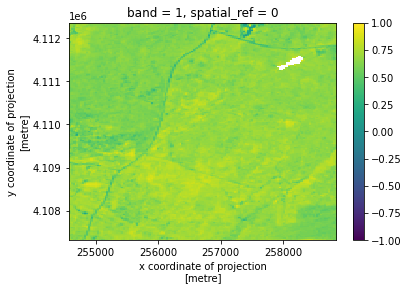

In [21]:
ndvi_clean = mask_crop_ndvi(all_bands=all_bands,
                            crop_bound=crop_bound,
                            pixel_qa=cl_mask,
                            vals=vals)

# View the final, cropped & cleaned NDVI data
ndvi_clean.plot.imshow(vmin=-1,
                       vmax=1)
plt.show()

In [22]:
#%%timeit
# Speed tests

# Open a single band using rioxarray
band = rxr.open_rasterio(band_paths[0], masked=True).rio.clip(crop_bound.geometry).squeeze()


In [23]:
#%%timeit
# Speed tests - note that you need to have rioxarray version 0.2 or greater for this to run 

# Open a single band using rioxarray
# band = rxr.open_rasterio(band_paths[0], masked=True).rio.clip(crop_bound.geometry,
#                                                               from_disk=True).squeeze()
# Clip the data
# band_crop = band.rio.clip(crop_bound.geometry,
#                          from_disk=True) # this parameter will only run with updated to your envt. the hub will be updated in the next few days


In [24]:
#%%timeit
import pyproj

# Use with caution - you must  have pyproject 3.0 or greater for this to work
#pyproj.set_use_global_context(True)

# Speed tests - note that you need to have rioxarray version 0.2 or greater for this to run 

# Open a single band using rioxarray - from_disk requires rioxarray  0.2
# band = rxr.open_rasterio(band_paths[0], masked=True).rio.clip(crop_bound.geometry,
#                                                              from_disk=True).squeeze()

